In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sys 
import os

# TODO: make more pythonic
# this line walks up file directory so rule-vetting is cwd
# Currently this breaks if chunk is run multiple times
os.chdir(os.path.dirname(os.path.dirname(os.path.dirname(os.path.dirname(sys.path[0])))))
print(os.getcwd())
print(sys.path[0])


%matplotlib inline
%load_ext autoreload
%autoreload 2

/accounts/grad/wtorous/rule-vetting
/accounts/grad/wtorous/rule-vetting/rulevetting/projects/csi_pecarn/notebooks
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [112]:
#from sklearn.preprocessing import StandardScaler
import rulevetting.api.viz as viz
from rulevetting.projects.csi_pecarn.dataset import Dataset

In [113]:
#j = Dataset().clean_data()
#k = Dataset().preprocess_data(j)
l = Dataset().get_data()

100%|██████████| 12/12 [00:00<00:00, 97.84it/s]
0it [00:00, ?it/s]

kwargs {'clean_data': {'use_kappa': True, 'use_robust_av': True}, 'preprocess_data': {'frac_missing_allowed': 0.05}, 'extract_features': {'drop_negative_columns': False}}
read all the csvs...
 ['analysisvariables.csv', 'clinicalpresentationfield.csv', 'clinicalpresentationoutside.csv', 'clinicalpresentationsite.csv', 'demographics.csv', 'injuryclassification.csv', 'injurymechanism.csv', 'kappa.csv', 'medicalhistory.csv', 'radiologyoutside.csv', 'radiologyreview.csv', 'radiologysite.csv']
merge all the dfs...


7it [00:00, 15.67it/s]


        SITE  CaseID ControlType PtAmbulatoryPriorArrival SectionGCSAvailable  \
id                                                                              
110002     1  110002        case                        N                   Y   
110015     1  110015        case                        Y                  ND   
110017     1  110017        case                        N                   Y   
120042     1  110012         ems                       ND                   Y   
120043     1  110019         ems                        N                   Y   

       TotalGCSAvailable  TotalGCSManual  GCSEye  VerbalGCS  MotorGCS  ...  \
id                                                                     ...   
110002               NaN             NaN     4.0        5.0       6.0  ...   
110015                ND             NaN     NaN        NaN       NaN  ...   
110017               NaN             NaN     4.0        5.0       6.0  ...   
120042               NaN             NaN  

In [60]:
print(j.shape)
print(k.shape)
print(l.shape)

(3314, 270)
(3314, 208)
(3314, 194)


# Load Datsa and Join into Single DF

In [45]:
# index df by study subject id and remove duplicate (SITE, caseID and ControlType) columns
analysis_var_df = pd.read_csv("data/csi_pecarn/raw/analysisvariables.csv").set_index(["StudySubjectID"])
cp_site_df = pd.read_csv("data/csi_pecarn/raw/clinicalpresentationsite.csv").set_index(["StudySubjectID"]).iloc[:,3:]
demographic_df = pd.read_csv("data/csi_pecarn/raw/demographics.csv").set_index(["studysubjectid"]).iloc[:,3:]
medical_history_df = pd.read_csv("data/csi_pecarn/raw/medicalhistory.csv").set_index(["StudySubjectID"]).iloc[:,3:]

cp_field_df = pd.read_csv("data/csi_pecarn/raw/clinicalpresentationfield.csv").set_index(["studysubjectid"]).iloc[:,3:]
cp_outside_df = pd.read_csv("data/csi_pecarn/raw/clinicalpresentationoutside.csv").set_index(["StudySubjectID"]).iloc[:,3:]

In [191]:
cp_outside_df.head()

,EDDocumentation,EDArrivalDate,EDArrivalDateND,EDArrivalTime,EDArrivalTimeND,ModeArrivalOutsideHospital,PtAmbulatoryPriorArrival,CervicalSpineImmobilization,CervicalSpineIntervCC,CervicalSpineIntervRLB,...,CervicalSpinePrecautionsOthertxt,MedsbyED,MedsGivenAna,MedsGivenGlu,MedsGivenPar,MedsGivenSed,MedsGivenOther,MedsGivenOthertxt,IntubatedED,OutsideEDDisposition
StudySubjectID,,,,,,,,,,,,,,,,,,,,,
110001,SITE,NaN,0,NaN,0,NaN,NaN,NaN,0,0,...,NaN,NaN,0,0,0,0,0,NaN,NaN,NaN
110002,SITE,NaN,0,NaN,0,NaN,NaN,NaN,0,0,...,NaN,NaN,0,0,0,0,0,NaN,NaN,NaN
110003,SITE,NaN,0,NaN,0,NaN,NaN,NaN,0,0,...,NaN,NaN,0,0,0,0,0,NaN,NaN,NaN
110004,ED,1/1/2000,0,14:45,0,ND,Y,N,0,0,...,NaN,N,0,0,0,0,0,NaN,N,T
110005,EDU,NaN,0,NaN,0,NaN,NaN,NaN,0,0,...,NaN,NaN,0,0,0,0,0,NaN,NaN,NaN


In [67]:
#eda_df = pd.concat([analysis_var_df,cp_site_df,demographic_df,medical_history_df])
eda_df = analysis_var_df
eda_df = eda_df.merge(cp_site_df,how="outer",left_index=True,right_on="StudySubjectID")
eda_df = eda_df.merge(demographic_df,how="outer",left_index=True,right_on="studysubjectid")
eda_df = eda_df.merge(medical_history_df,how="outer",left_index=True,right_on="StudySubjectID")
eda_df = eda_df.merge(cp_field_df,how="outer",left_index=True,right_on="studysubjectid")
eda_df = eda_df.merge(cp_outside_df,how="outer",left_index=True,right_on="StudySubjectID")

# add binary outcome column
eda_df['csi_injury'] = np.where(eda_df['ControlType']=='case', 1, 0)
outcome_def = 'csi_injury'  # output

eda_df_numeric = eda_df.select_dtypes([np.number])

In [68]:
#print(medical_history_df.shape)

print(eda_df.shape)
# Drop 145 non numeric columns
print(eda_df_numeric.shape)
print(eda_df_numeric.columns)

(3314, 410)
(3314, 270)
Index(['SITE', 'CaseID', 'AlteredMentalStatus', 'LOC', 'ambulatory',
       'FocalNeuroFindings', 'PainNeck', 'PosMidNeckTenderness', 'TenderNeck',
       'Torticollis',
       ...
       'MinorInjuriesExt', 'CervicalSpinePrecautionsCC_y',
       'CervicalSpinePrecautionsRLB_y', 'CervicalSpinePrecautionsOther_y',
       'MedsGivenAna', 'MedsGivenGlu', 'MedsGivenPar', 'MedsGivenSed',
       'MedsGivenOther', 'csi_injury'],
      dtype='object', length=270)


In [87]:
# get list of columns with only two recorded outcomes
binary_columns = eda_df_numeric.columns[eda_df_numeric.nunique()==2]
print(binary_columns)
binary_eda_data = eda_df_numeric[binary_columns]

cont_columns = eda_df_numeric.columns[eda_df_numeric.nunique()!=2]
print(cont_columns)
# outcome is binary
cont_eda_data = eda_df_numeric[cont_columns]
cont_eda_data[outcome_def] = eda_df[outcome_def]

Index(['AlteredMentalStatus', 'LOC', 'ambulatory', 'FocalNeuroFindings',
       'PainNeck', 'PosMidNeckTenderness', 'TenderNeck', 'Torticollis',
       'SubInj_Head', 'SubInj_Face',
       ...
       'MinorInjuriesExt', 'CervicalSpinePrecautionsCC_y',
       'CervicalSpinePrecautionsRLB_y', 'CervicalSpinePrecautionsOther_y',
       'MedsGivenAna', 'MedsGivenGlu', 'MedsGivenPar', 'MedsGivenSed',
       'MedsGivenOther', 'csi_injury'],
      dtype='object', length=243)
Index(['SITE', 'CaseID', 'LocEvalPhysician', 'CervicalSpineImmobilization_x',
       'TotalGCSManual_x', 'GCSEye_x', 'VerbalGCS_x', 'MotorGCS_x',
       'AgeInYears', 'BodyAsAWhole1', 'BodyAsAWhole4', 'Genitourinary1',
       'Endocrinological1', 'HematologicLymphatic2', 'EMSEstimateTime',
       'TotalGCSManual_y', 'GCSEye_y', 'VerbalGCS_y', 'MotorGCS_y',
       'TotalGCS_y', 'OtherInjuriesFlank_y', 'TotalGCSManual', 'GCSEye',
       'VerbalGCS', 'MotorGCS', 'TotalGCS', 'PtTenderNeckAnt'],
      dtype='object')


<ipython-input-87-a9db6bf50042>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cont_eda_data[outcome_def] = eda_df[outcome_def]


In [140]:
print(eda_df_numeric.shape)
print(binary_eda_data.shape)
print(cont_eda_data.shape)

(3314, 270)
(3314, 243)
(3314, 28)


# Summary EDA

In [71]:
eda_df_numeric.describe()

,SITE,CaseID,AlteredMentalStatus,LOC,ambulatory,FocalNeuroFindings,PainNeck,PosMidNeckTenderness,TenderNeck,Torticollis,...,MinorInjuriesExt,CervicalSpinePrecautionsCC_y,CervicalSpinePrecautionsRLB_y,CervicalSpinePrecautionsOther_y,MedsGivenAna,MedsGivenGlu,MedsGivenPar,MedsGivenSed,MedsGivenOther,csi_injury
count,3314.000000,3.314000e+03,3230.000000,3047.000000,3122.000000,2979.000000,3131.000000,3222.000000,3222.000000,3078.000000,...,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000
mean,9.738081,9.853706e+05,0.182972,0.376764,0.227739,0.122524,0.356116,0.285537,0.375854,0.051982,...,0.034701,0.101690,0.066385,0.007242,0.046771,0.012674,0.015088,0.026252,0.053410,0.162945
std,4.826812,4.836199e+05,0.386704,0.484655,0.419440,0.327945,0.478927,0.451740,0.484418,0.222026,...,0.183050,0.302286,0.248992,0.084804,0.211180,0.111878,0.121919,0.159909,0.224883,0.369371
min,1.000000,1.100010e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,6.107250e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,10.000000,1.011614e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,15.000000,1.512485e+06,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,17.000000,1.713132e+06,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [110]:
binary_corrs = binary_eda_data.corr(method='spearman')
cont_corrs = cont_eda_data.corr(method='spearman')
#corrmap = sns.clustermap(corrs, cmap=viz.cmap_div, vmin=-1, vmax=1, cbar_kws={'label': 'Correlation'})
#corrmap.ax_row_dendrogram.set_visible(False)
#corrmap.ax_col_dendrogram.set_visible(False)

In [111]:
print(cont_corrs)

                                   SITE    CaseID  LocEvalPhysician  \
SITE                           1.000000  0.997371          0.003065   
CaseID                         0.997371  1.000000          0.002395   
LocEvalPhysician               0.003065  0.002395          1.000000   
CervicalSpineImmobilization_x -0.042962 -0.041722          0.064148   
TotalGCSManual_x              -0.069981 -0.072234         -0.155359   
GCSEye_x                      -0.056777 -0.059537         -0.144247   
VerbalGCS_x                   -0.034421 -0.034734         -0.121841   
MotorGCS_x                    -0.045087 -0.047006         -0.122299   
AgeInYears                    -0.076338 -0.073239         -0.006638   
BodyAsAWhole1                       NaN       NaN               NaN   
BodyAsAWhole4                       NaN       NaN               NaN   
Genitourinary1                      NaN       NaN               NaN   
Endocrinological1                   NaN       NaN               NaN   
Hemato

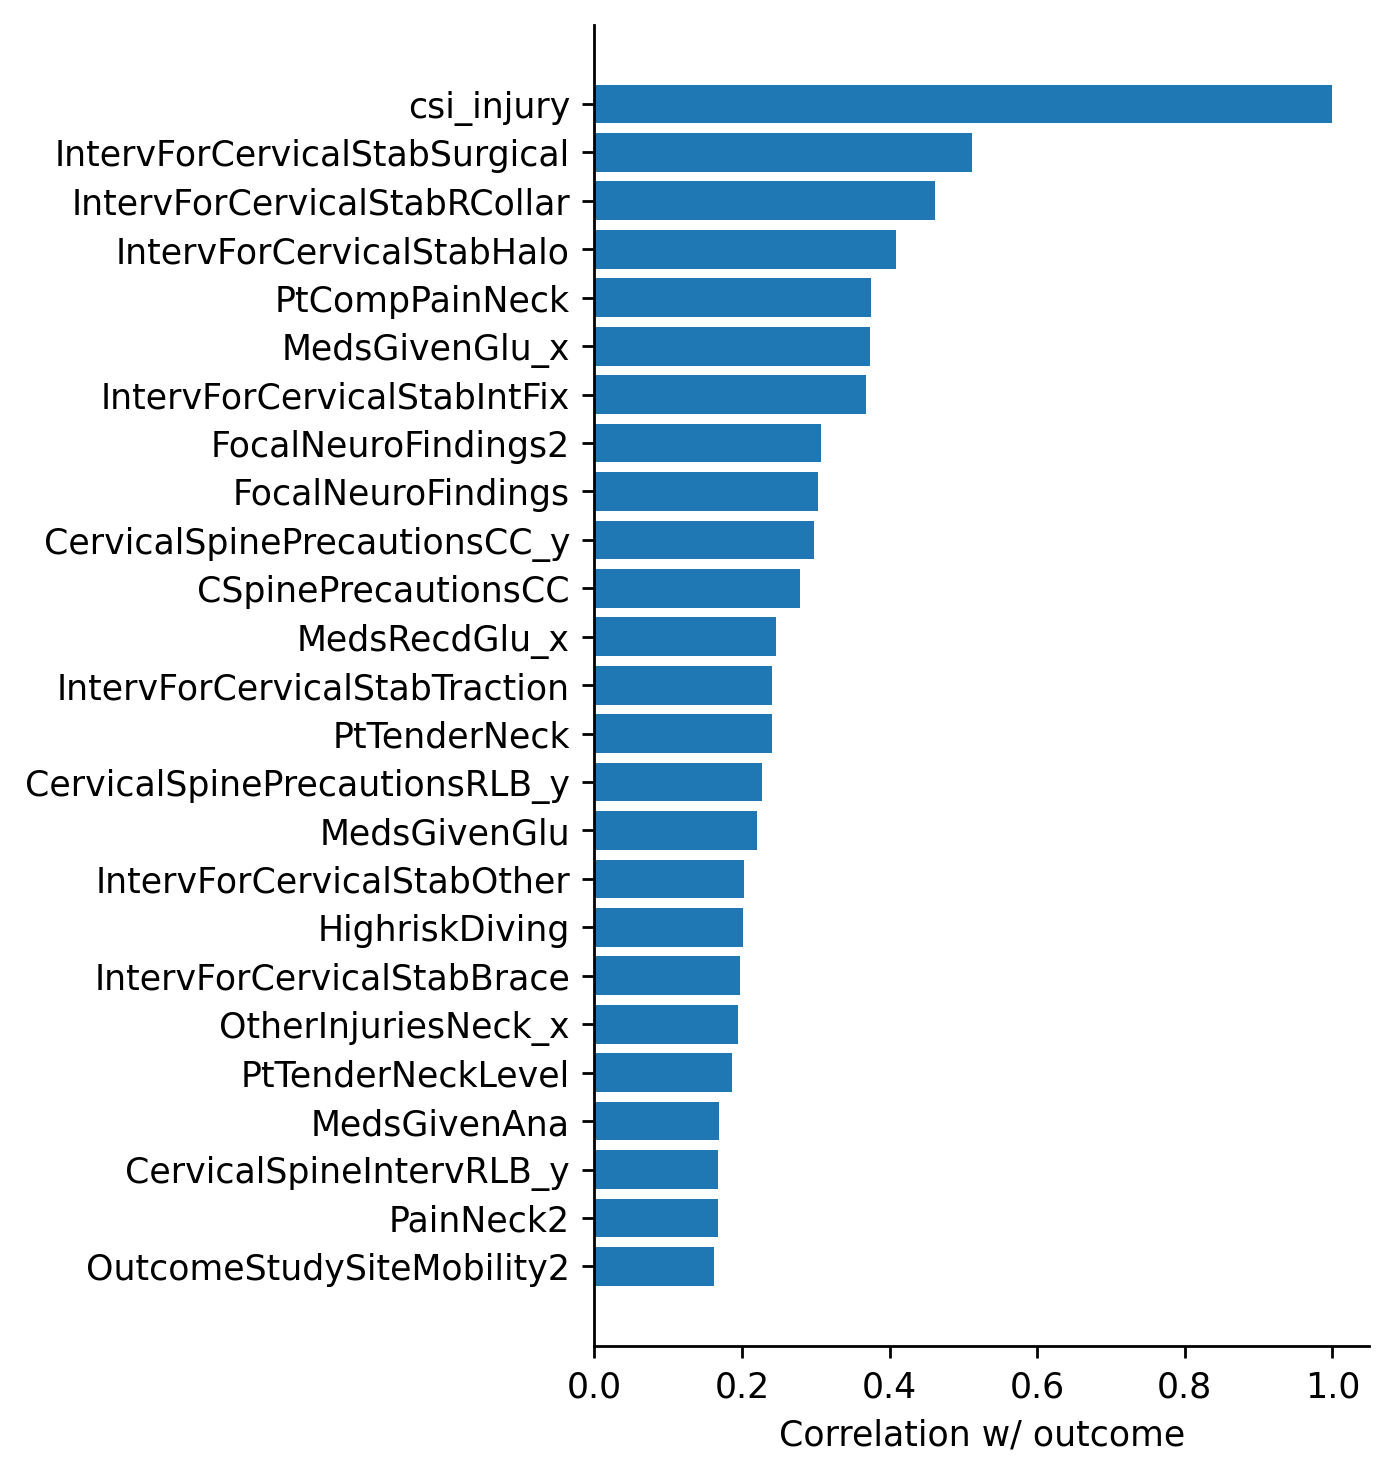

In [112]:
plt.figure(dpi=250, figsize=(4, 7))
vals = binary_corrs[outcome_def]
args = np.argsort(vals)
labs = vals.index.values[args]
ax = plt.subplot(111)
plt.barh(labs[-25:], vals[args][-25:])
plt.xlabel('Correlation w/ outcome')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

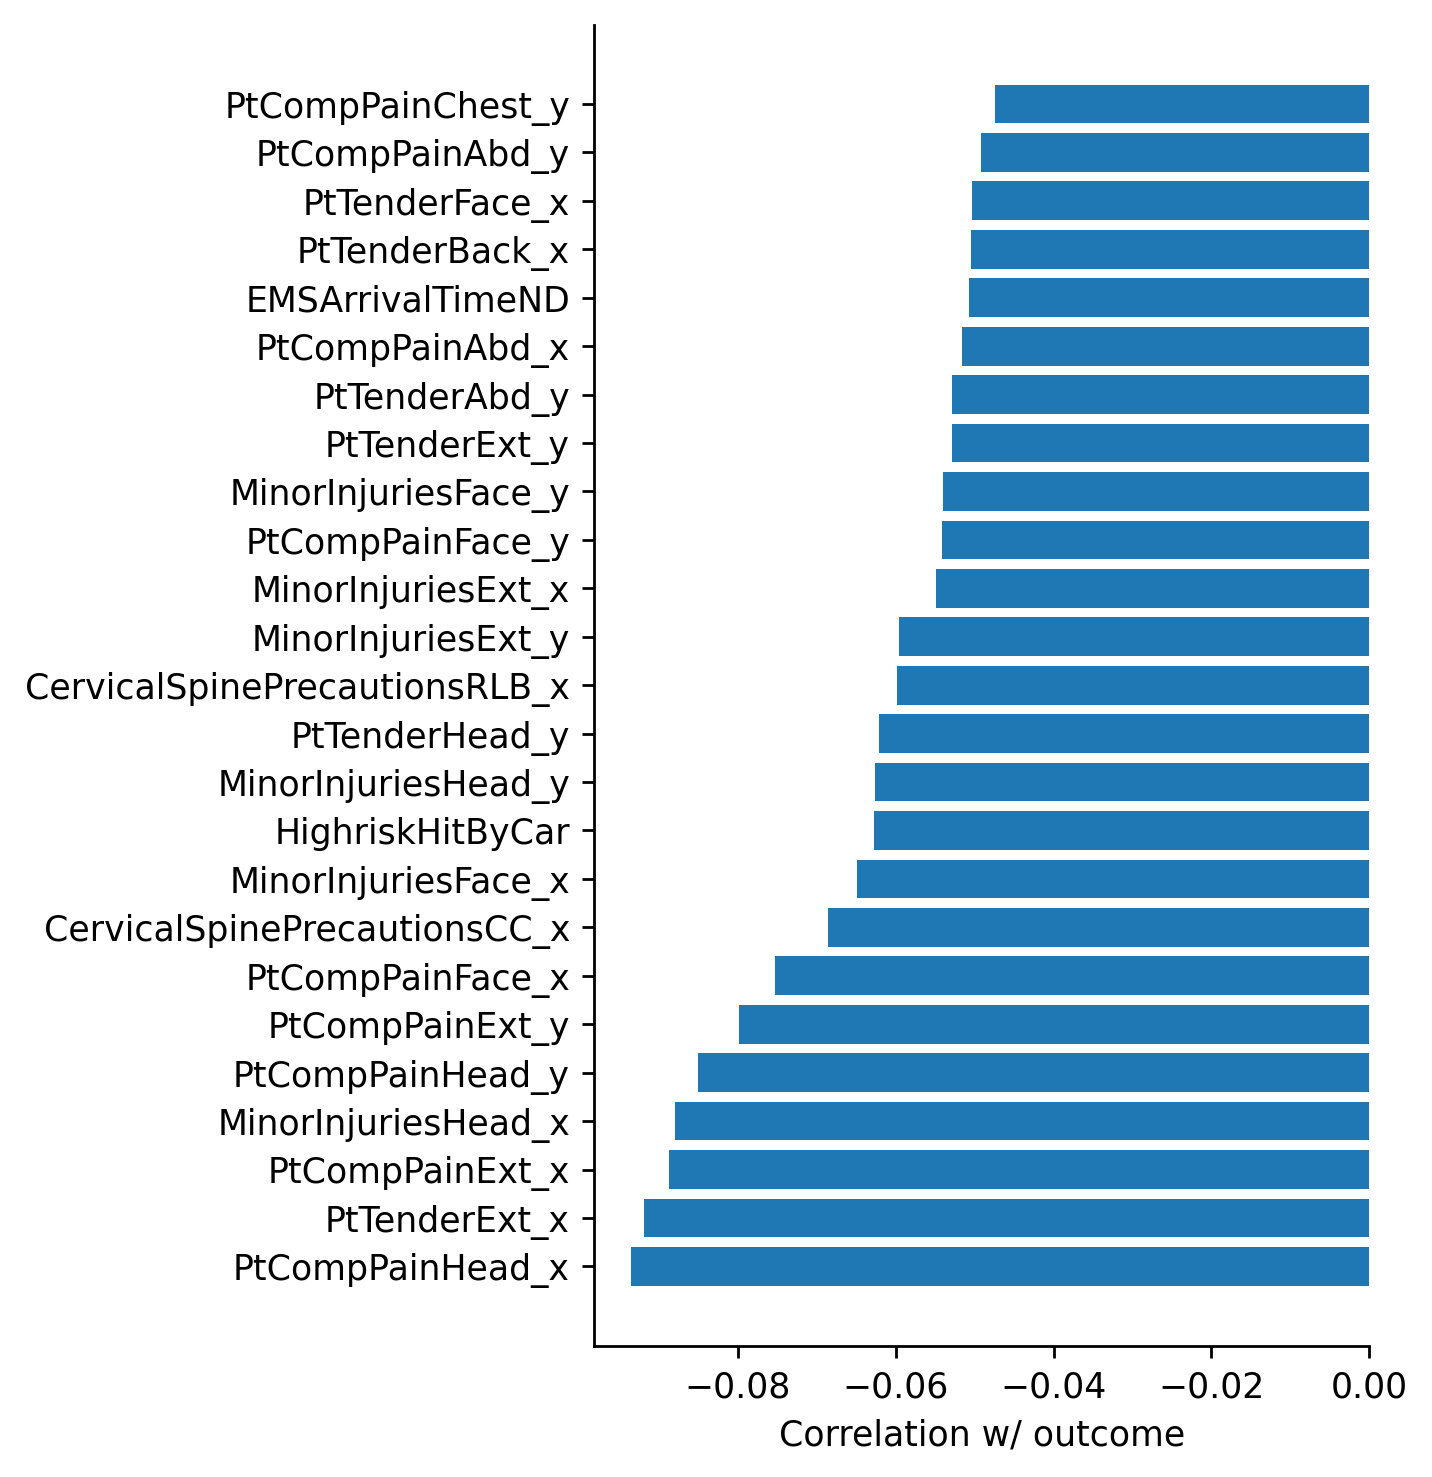

In [113]:
plt.figure(dpi=250, figsize=(4, 7))
vals = binary_corrs[outcome_def]
args = np.argsort(vals)
labs = vals.index.values[args]
ax = plt.subplot(111)
plt.barh(labs[:25], vals[args][:25])
plt.xlabel('Correlation w/ outcome')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

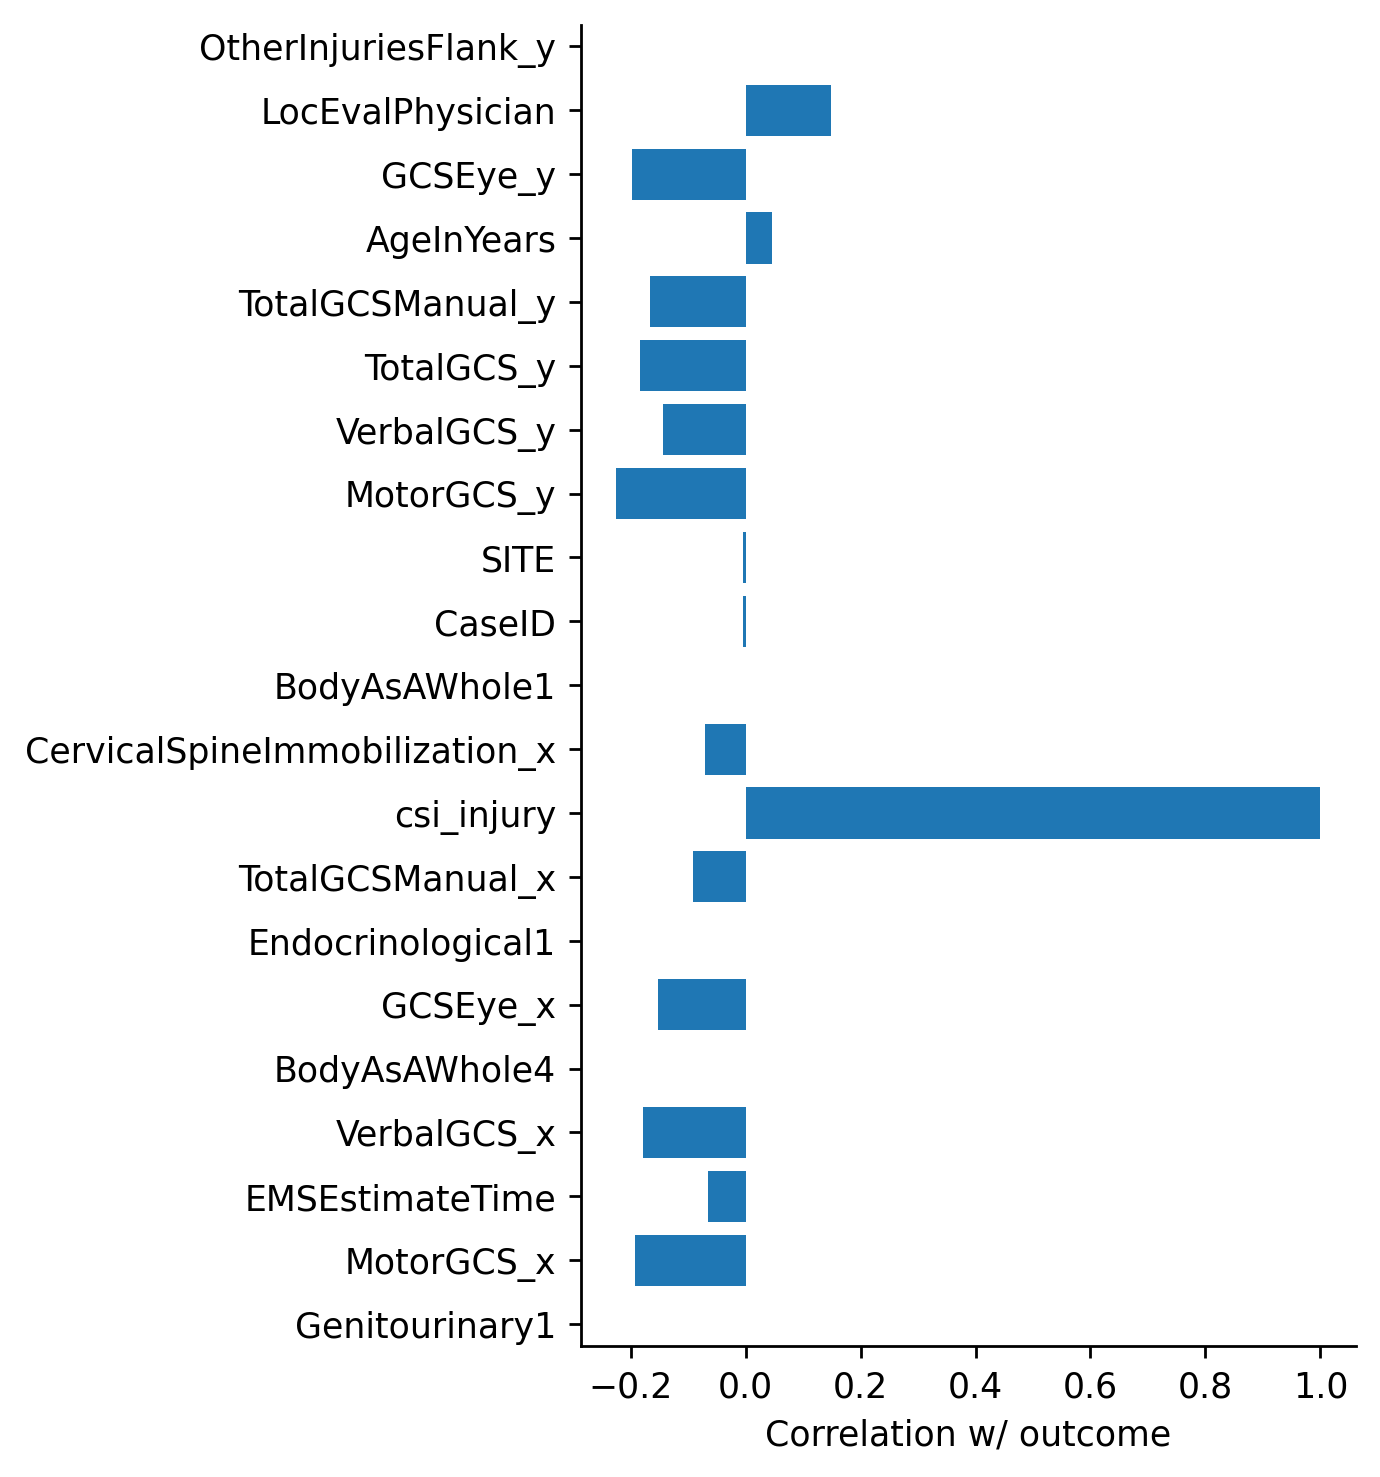

In [114]:
plt.figure(dpi=250, figsize=(4, 7))
vals = cont_corrs[outcome_def]
args = np.argsort(vals)
labs = vals.index.values[args]
ax = plt.subplot(111)
plt.barh(labs, vals[args])
plt.xlabel('Correlation w/ outcome')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

# EDA of Missingness

In [115]:
# get percent missing by column
missing_frac = (eda_df_numeric.isna().sum() / eda_df_numeric.shape[0]) * 100
print(missing_frac.sort_values(ascending=False)[:25])

bin_missing_frac = (binary_eda_data.isna().sum() / binary_eda_data.shape[0]) * 100
print(bin_missing_frac.sort_values(ascending=False)[:25])

TotalGCSManual         97.435124
VerbalGCS              94.689197
GCSEye                 94.689197
MotorGCS               94.689197
TotalGCS               94.689197
TotalGCSManual_y       92.033796
EMSEstimateTime        88.563669
TotalGCSManual_x       78.394689
VerbalGCS_y            62.884731
TotalGCS_y             62.884731
GCSEye_y               62.884731
MotorGCS_y             62.884731
MotorGCS_x             47.404949
GCSEye_x               47.404949
VerbalGCS_x            47.404949
FocalNeuroFindings     10.108630
FocalNeuroFindings2     9.837055
LOC                     8.056729
HighriskMVC             7.724804
Torticollis             7.121304
Torticollis2            7.030779
ambulatory              5.793603
PainNeck                5.522028
PainNeck2               5.250453
Clotheslining           3.379602
dtype: float64
FocalNeuroFindings       10.108630
FocalNeuroFindings2       9.837055
LOC                       8.056729
HighriskMVC               7.724804
Torticollis         

In [124]:
complete_binary_covar = binary_columns[bin_missing_frac==0]
print(len(complete_binary_covar))

missing_columns = binary_columns[bin_missing_frac!=0]
print(len(missing_columns))

214
29


In [130]:
binary_missing_bools = binary_eda_data[missing_columns].isna()
binary_missing_corrs = binary_missing_bools.corr(method='spearman')

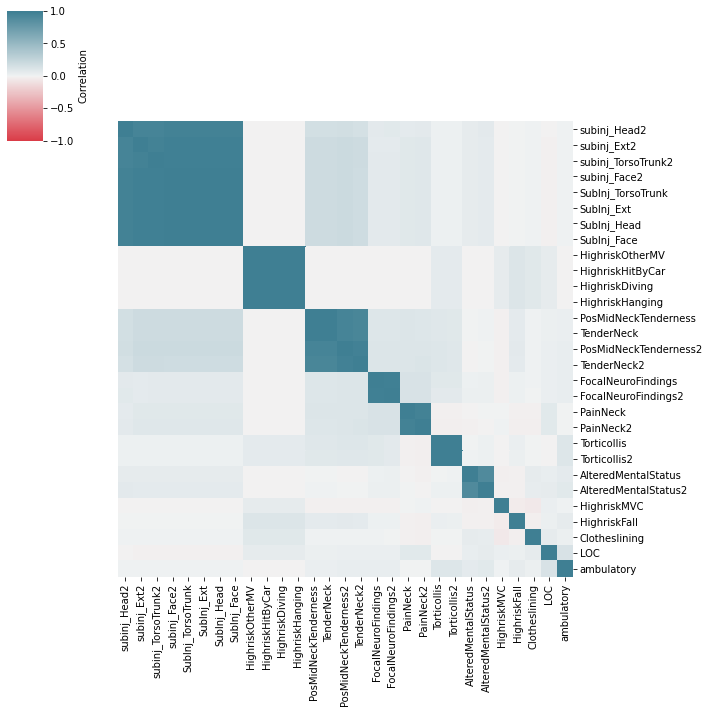

In [131]:
corrmap = sns.clustermap(binary_missing_corrs, cmap=viz.cmap_div, vmin=-1, vmax=1, cbar_kws={'label': 'Correlation'})
corrmap.ax_row_dendrogram.set_visible(False)
corrmap.ax_col_dendrogram.set_visible(False)

# EDA of Demographic Data

In [207]:
eda_demographic_df = pd.read_csv("data/csi_pecarn/raw/demographics.csv").set_index(["studysubjectid"])
print(eda_demographic_df.columns)

Index(['site', 'caseid', 'controltype', 'AgeInYears', 'Gender', 'Race',
       'Ethnicity', 'PayorType', 'PayorTypeCI', 'PayorTypeMA'],
      dtype='object')


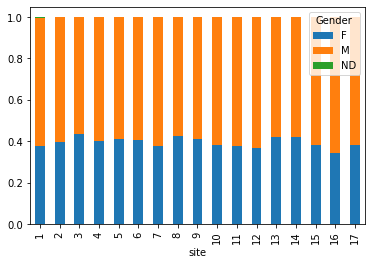

In [205]:
gender_df = eda_demographic_df.groupby('site')['Gender'].value_counts(normalize=True)
gender_df.unstack().plot(kind='bar', stacked=True)

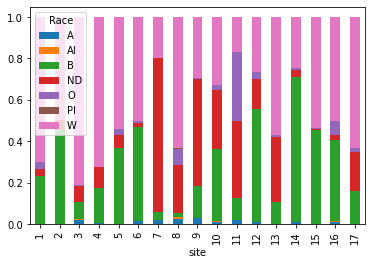

In [208]:
race_df = eda_demographic_df.groupby('site')['Race'].value_counts(normalize=True)
race_df.unstack().plot(kind='bar', stacked=True)

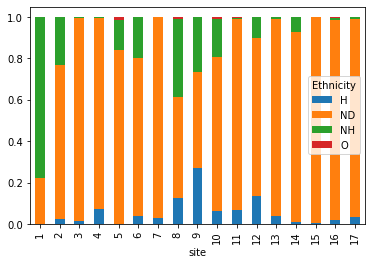

In [209]:
ethnicity_df = eda_demographic_df.groupby('site')['Ethnicity'].value_counts(normalize=True)
ethnicity_df.unstack().plot(kind='bar', stacked=True)

site  PayorType
1     CI           0.594595
      MA           0.277027
      ND           0.108108
      SU           0.013514
      OG           0.006757
Name: PayorType, dtype: float64


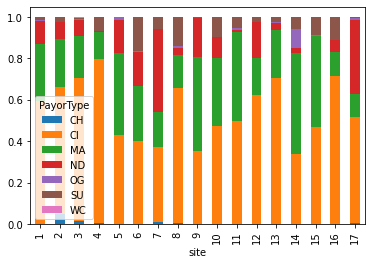

In [234]:
payor_df = eda_demographic_df.groupby('site')['PayorType'].value_counts(normalize=True)
print(payor_df.head())
payor_df.unstack().plot(kind='bar', stacked=True)

<ipython-input-235-d97eedaba98b>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  age_df['AgeBin'] = pd.cut(age_df['AgeInYears'], bins, labels=names)


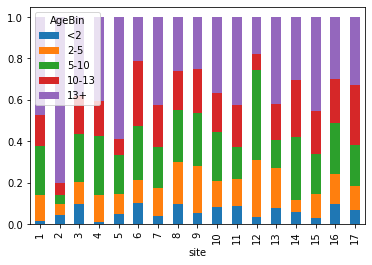

In [235]:
age_df = eda_demographic_df[['site','AgeInYears']]


bins = [0, 2, 5, 10, 13, np.inf]
names = ['<2', '2-5', '5-10', '10-13', '13+']

age_df['AgeBin'] = pd.cut(age_df['AgeInYears'], bins, labels=names)

age_range_df = age_df.groupby('site')['AgeBin'].value_counts(normalize=True)
#print(age_range_df)
age_range_df.unstack().plot(kind='bar', stacked=True)

Function below

In [189]:
def numeric_to_binary(input_df):
    '''
    This function properly encodes variables are recorded as numeric but can be encoded as binary. 
    '''
    numeric_data = input_df.select_dtypes([np.number]) # separate data that is already numeric
    char_data = input_df.select_dtypes([np.object]) # gets columns encoded as strings
    binary_data = pd.DataFrame(index=input_df.index) # study subject ID
    
    for column in char_data:
        char_column = char_data[column] # select column
        unique_values = pd.unique(char_column) # get unique entries
        
        # encode yes as 1, no as 0
        if (('Y' in unique_values)|('A' in unique_values)) & ('N' in unique_values):
            conditions  = [char_column == 'Y',char_column == 'A',char_column == 'N']
            encodings = [1,1,0]
            binary_encoded = np.select(conditions, encodings, default=np.nan)
            col_name = column+"_binary"
            binary_data[col_name] = binary_encoded
         
    result_df = pd.merge(numeric_data,binary_data,left_on=numeric_data.index,right_on=binary_data.index)
    return result_df

In [190]:
numeric_to_binary(medical_history_df)

,key_0,FormOff,BodyAsAWhole0,BodyAsAWhole1,BodyAsAWhole2,BodyAsAWhole3,BodyAsAWhole4,BodyAsAWhole5,BodyAsAWhole6,Genitourinary1,...,Cardiovascular_binary,Respiratory_binary,Gastrointestinal_binary,Genitourinary_binary,Musculoskeletal_binary,Neurological_binary,Endocrinological_binary,DermatologicalSkin_binary,HematologicLymphatic_binary,Medications_binary
0,110001,0,0,0,0,0,0,0,0,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,110002,1,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,110003,0,0,0,0,0,0,0,0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,110004,1,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,110005,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3309,1743310,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3310,1743311,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3311,1743312,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3312,1743313,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
